This notebook was made during Vincent Warmerdam's Probabilistic Programming session at PyData London 2017. He and I have been discussing the pros and cons of PyMC3 and Edward, so I rewrote his simple PyMC3 Bayesian inference example in Edward, comparing MAP, Monte Carlo, and Variational Inference approaches.

In [1]:
import numpy as np
import tensorflow as tf
import edward as ed

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# create our dataset
N = 10
y = np.random.normal(1, 2, (10,))

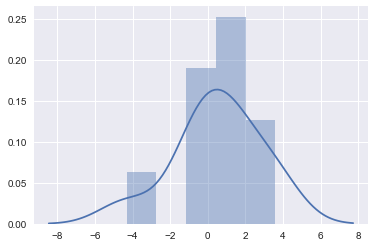

In [29]:
# observed distribution
sns.distplot(y)

In [4]:
# model
mu_mod = ed.models.Normal(loc=0., scale=10.)
sigma_mod = ed.models.Normal(loc=0., scale=10.)
# the softplus makes negative standard deviations impossible
y_obs = ed.models.Normal(loc=mu_mod*tf.ones(N), scale=tf.nn.softplus(sigma_mod)*tf.ones(N))

In [34]:
# inference
# MAP first to find good starting points
mu_hat = ed.models.PointMass(tf.Variable(0.))
sigma_hat = ed.models.PointMass(tf.nn.softplus(tf.Variable(1.)))

map_inference = ed.inferences.MAP({mu_mod: mu_hat, sigma_mod: sigma_hat}, {y_obs: y.astype(np.float32)})
map_inference.run()

mu_hat_inferred, sigma_hat_inferred = sess.run([mu_hat.value(), sigma_hat.value()])
print(mu_hat_inferred, sigma_hat_inferred)

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 28.475
0.495998 2.06046


In [35]:
# MCMC, starting from MAP estimate
T = 100000
mu_sample = ed.models.Empirical(tf.Variable(tf.ones(T)*mu_hat_inferred))
sigma_sample = ed.models.Empirical(tf.Variable(tf.ones(T)*sigma_hat_inferred))

inference = ed.inferences.HMC({mu_mod: mu_sample, sigma_mod: sigma_sample}, {y_obs: y.astype(np.float32)})
inference.run()

100000/100000 [100%] ██████████████████████████████ Elapsed: 172s | Acceptance Rate: 0.984


In [47]:
# VI, starting from MAP estimate
mu_vi = ed.models.NormalWithSoftplusScale(loc=tf.Variable(mu_hat_inferred), scale=tf.Variable(1.))
sigma_vi = ed.models.NormalWithSoftplusScale(loc=tf.Variable(sigma_hat_inferred), scale=tf.Variable(1.))

inference = ed.inferences.KLqp({mu_mod: mu_vi, sigma_mod: sigma_vi}, {y_obs: y.astype(np.float32)})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 27.307


In [13]:
sess = ed.get_session()  # tensorflow session

In [36]:
# MCMC samples
mu_values, sigma_values = sess.run([mu_sample.params, sigma_sample.params])

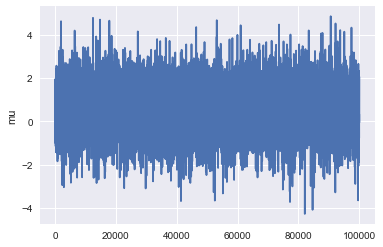

In [56]:
plt.plot(mu_values)
plt.ylabel('mu')

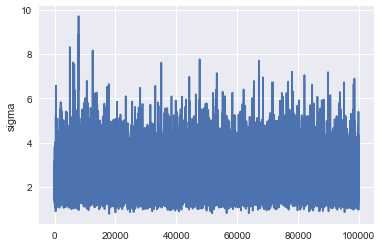

In [57]:
plt.plot(sigma_values)
plt.ylabel('sigma')

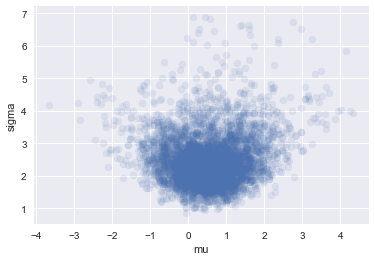

In [60]:
plt.scatter(mu_values[-5000:], np.abs(sigma_values[-5000:]), alpha=0.1)
plt.xlabel('mu')
plt.ylabel('sigma')
plt.show()

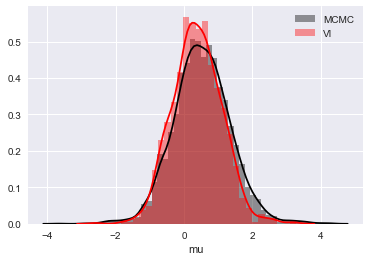

In [53]:
sns.distplot(mu_values[-5000:], color='k', label='MCMC')
sns.distplot(sess.run(mu_vi.sample(1000)), color='r', label='VI')
plt.legend()
plt.xlabel('mu')
plt.show()

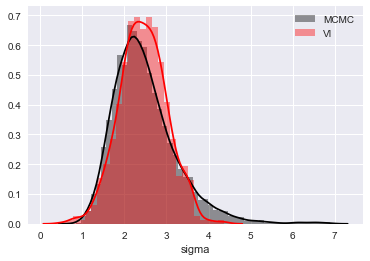

In [54]:
sns.distplot(np.abs(sigma_values[-5000:]), color='k', label='MCMC')
sns.distplot(np.abs(sess.run(sigma_vi.sample(1000))), color='r', label='VI')
plt.legend()
plt.xlabel('sigma')
plt.show()